# Amazon Redset Workload Forecasting

## What is Redset?
Redset is a dataset released by Amazon in 2024, comprising three months of user query metadata from a selected sample of Amazon Redshift instances. It includes query metadata for **200 provisioned and 200 serverless instances**, offering insights into user interactions with these database services. While not representative of the entire Redshift fleet, Redset serves as a valuable resource for developing **new benchmarks and exploring machine learning techniques**, such as **workload forecasting**, tailored to these specific workloads.

## What we perform in this notebook?

In this notebook, we analyze **Amazon Redset**, a dataset containing query metadata from Amazon Redshift instances, to explore **workload forecasting techniques** for **intelligent resource scaling**. Our primary objectives are:

### 1. Baseline Model Evaluation
- We evaluate **traditional forecasting baselines**, such as:
  - **AutoGluon DeepAR**
  - **Seasonal Naive Models**
- These models establish reference points for **workload prediction**.

### 2. Development of RNN-based Forecasting Models
- We implement **Recurrent Neural Network (RNN)-based models** to improve **forecasting accuracy**.
- These models aim to **capture complex workload patterns** and **improve upon the baselines**.

### 3. Comparison Between Baselines and RNN-based Approaches
- Using the **Redset dataset**, we compare the performance of our **custom RNN models** with:
  - **AutoGluon DeepAR**
  - **Statistical forecasting methods** (e.g., ARIMA, ETS)
- We use metrics such as **Q-error** and **forecast accuracy** to assess improvements.

---

### Reference
For more details on the forecasting methodologies and benchmark comparisons, we refer to the **attached paper: "Forecasting Algorithms for Intelligent Resource Scaling: An Experimental Analysis"**.  
This paper provides insights into **workload forecasting challenges**, evaluation metrics, and strategies for improving predictive accuracy in cloud environments.

In [1]:
import pandas as pd
from datetime import datetime
from utility.helpers import DataManager
# import visualization
from utility.baseline_models import DeepAR
import matplotlib.pyplot as plt
import seaborn as sns
datamanager = DataManager('provisioned', 96)
import logging
import os



/Applications/miniconda/envs/mxnet310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the data
data = datamanager.load_data()
# Convert timestamp to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])
# Sort the data by timestamp
data = data.sort_values('timestamp')

In [3]:
# Visualize data
# visualization.visualize_data(data)
data
import numpy as np
data['query_count'] = np.log1p(data['query_count'])  # Apply log transform

In [ ]:
# Split into training and test data:
# Following the approach in the paper (p. 132), for a cluster with N weeks of data,
# the first train-test split includes N-2 weeks for training and the following week
# for testing. The second train-test split contains the first N-1 weeks for training
# and the following week for testing, representing a scenario of re-training a model
# each week and forecasting for the next week

train1, test1, train2, test2 = datamanager.train_test_split(data)

print(f"train1 shape: {train1.shape}")
print(f"test1 shape: {test1.shape}")
print(f"train2 shape: {train2.shape}")
print(f"test2 shape: {test2.shape}")

print(train1.iloc[-1])
print(test1.iloc[0])
print(train1.iloc[-1])
print(test1.iloc[0])

train1 shape: (1919, 5)
test1 shape: (168, 5)
train2 shape: (2087, 5)
test2 shape: (48, 5)
instance_id                       96
timestamp        2024-05-19 23:00:00
query_count                 0.693147
runtime                         19.0
bytes_scanned                    0.0
Name: 141583, dtype: object
instance_id                       96
timestamp        2024-05-20 00:00:00
query_count                 2.639057
runtime                      20678.0
bytes_scanned                 3045.0
Name: 190321, dtype: object
instance_id                       96
timestamp        2024-05-19 23:00:00
query_count                 0.693147
runtime                         19.0
bytes_scanned                    0.0
Name: 141583, dtype: object
instance_id                       96
timestamp        2024-05-20 00:00:00
query_count                 2.639057
runtime                      20678.0
bytes_scanned                 3045.0
Name: 190321, dtype: object
instance_id                       96
timestamp        202

## Baseline Model: DeepAR

In [5]:
print(train1.isnull().sum())  # Check for NaNs
train_data = train1.fillna(0)  # Fill missing values with zero

instance_id      0
timestamp        0
query_count      0
runtime          0
bytes_scanned    0
dtype: int64


In [6]:
# Define the forecast horizon (e.g., forecast the next 48 hours)
prediction_length = 168  # 7 days

# Get the last timestamp from training data
last_train_ts = train1['timestamp'].max()
print("Last training timestamp:", last_train_ts)

# Forecast should start one hour after the last training timestamp
start_forecast = last_train_ts + pd.Timedelta(hours=1)
end_forecast = start_forecast + pd.Timedelta(hours=prediction_length - 1)
print("Forecast horizon:", start_forecast, "to", end_forecast)

# Filter test1 to only include rows within the forecast horizon
test_forecast = test1[(test1['timestamp'] >= start_forecast) & (test1['timestamp'] <= end_forecast)]
print("Filtered test_forecast timestamps:")
print(test_forecast[['timestamp', 'query_count']].count())

hyperparameters = {
    'DeepAR': {
        'num_layers': 2,          # Increase to 3 layers for better representation
        'hidden_size': 40,        # Slightly larger hidden size
        'dropout_rate': 0.2,      # Higher dropout to prevent overfitting
        'learning_rate': 5e-4,    # Reduce learning rate for stable training
        'patience': 5,           # Increase patience for early stopping
        'max_epochs': 50,        # More epochs for better convergence
        'context_length': 48,
        'use_feat_dynamic_real': True,  # Use additional features (hour, day_of_week),
        'batch_size': 8,         
        'freq': 'H',  # Use uppercase "H" for hourly data
        'verbosity': 2
    }
}

os.environ["OMP_NUM_THREADS"] = "2"  # Prevent excessive parallelism
os.environ["AUTOGLUON_DEVICE"] = "cpu"  # Ensure CPU-only execution

# Enable logging (Fix: Force verbose output)
logging.basicConfig(level=logging.INFO)
logging.getLogger("autogluon").setLevel(logging.DEBUG)

# Instantiate the DeepAR model using AutoGluon
model = DeepAR(prediction_length=prediction_length, freq="h",hyperparameters=hyperparameters)

# Train the model on the training data
model.train(train1, target_column="query_count")

# Generate predictions on the filtered test data (forecast horizon)
predictions_df = model.predict(test_forecast, target_column="query_count")
print("Predictions:")
print(predictions_df.head())

# Save the trained model to disk
# model.save_model()

No path specified. Models will be saved in: "AutogluonModels/ag-20250218_224730"
Beginning AutoGluon training...
AutoGluon will save models to '/Users/sagnikdas/GitHub/WF-ML/AutogluonModels/ag-20250218_224730'


Last training timestamp: 2024-05-19 23:00:00
Forecast horizon: 2024-05-20 00:00:00 to 2024-05-26 23:00:00
Filtered test_forecast timestamps:
timestamp      168
query_count    168
dtype: int64
Initializing DeepARAutogluonTS Model...
Training started using DeepAR...


=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.16
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.3.0: Thu Jan  2 20:24:06 PST 2025; root:xnu-11215.81.4~3/RELEASE_ARM64_T8103
CPU Count:          8
GPU Count:          0
Memory Avail:       1.65 GB / 8.00 GB (20.7%)
Disk Space Avail:   12.07 GB / 228.27 GB (5.3%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': SMAPE,
 'freq': 'h',
 'hyperparameters': {'DeepAR': {'batch_size': 8,
                                'context_length': 48,
                                'dropout_rate': 0.2,
                                'freq': 'H',
                                'hidden_size': 40,
                                'learning_rate': 0.0005,
                                'max_epochs': 50,
                                'num_layers': 2,
                                'patience': 5,
                                'use_fea

Training completed using DeepAR.


Saving /Users/sagnikdas/GitHub/WF-ML/AutogluonModels/ag-20250218_224730/models/cached_predictions.pkl


Predictions:
            timestamp      mean  lower_bound  upper_bound
0 2024-05-27 00:00:00  2.547422     0.253494     5.205415
1 2024-05-27 01:00:00  1.451025    -0.593843     3.311512
2 2024-05-27 02:00:00  1.631199    -0.655617     3.903819
3 2024-05-27 03:00:00  1.560896    -0.251854     3.792314
4 2024-05-27 04:00:00  1.469874     0.129476     3.094191


In [7]:
evaluation_results = model.evaluate(test_forecast, target_column="query_count")
print("Evaluation Metrics:")
print(evaluation_results)

Model not specified in predict, will default to the model with the best validation score: DeepAR


Loading: /Users/sagnikdas/GitHub/WF-ML/AutogluonModels/ag-20250218_224730/models/cached_predictions.pkl
Loading: /Users/sagnikdas/GitHub/WF-ML/AutogluonModels/ag-20250218_224730/models/cached_predictions.pkl
Saving /Users/sagnikdas/GitHub/WF-ML/AutogluonModels/ag-20250218_224730/models/cached_predictions.pkl


Evaluation Metrics:
Q-error: 1.5549
MAE: 0.9451
RME: 0.3314
Evaluation Metrics:
{'q_error': 1.5548923774217056, 'mae': 0.9450605498851362, 'rme': 0.33138539038123616}


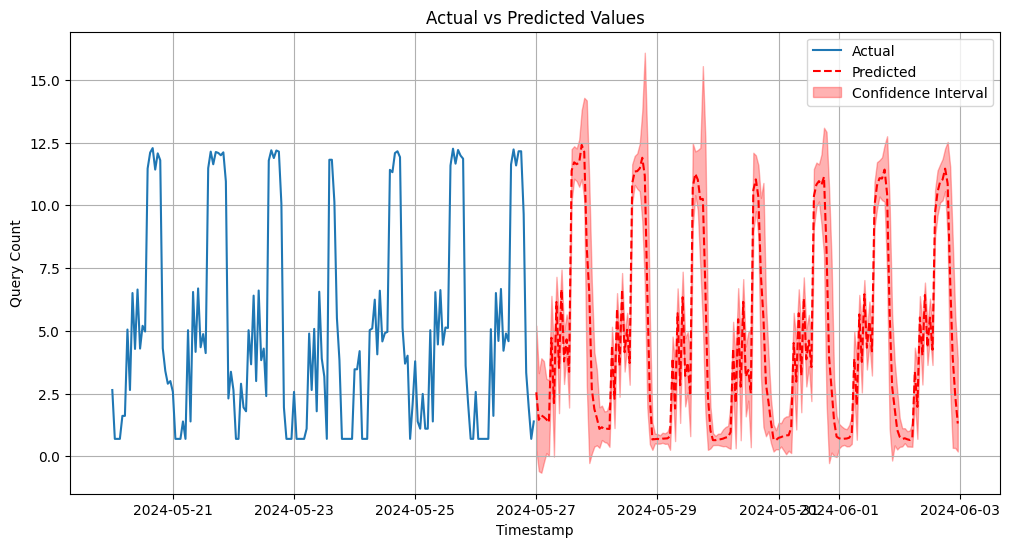

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Optionally, convert timestamps to datetime if they aren't already
test1['timestamp'] = pd.to_datetime(test1['timestamp'])
predictions_df['timestamp'] = pd.to_datetime(predictions_df['timestamp'])

plt.figure(figsize=(12, 6))

plt.plot(test_forecast['timestamp'], test_forecast['query_count'], label='Actual')
plt.plot(predictions_df['timestamp'], predictions_df['mean'], label='Predicted', linestyle='--', color='red')

# Fill the confidence interval if available
plt.fill_between(predictions_df['timestamp'], 
                 predictions_df['lower_bound'], 
                 predictions_df['upper_bound'], 
                 color='red', alpha=0.3, label='Confidence Interval')

plt.xlabel('Timestamp')
plt.ylabel('Query Count')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()